In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm

In [35]:
!pip install gensim
!pip install spacy
!pip install nltk
!python -m spacy download en
!pip install wordcloud

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 12.8 MB 5.1 MB/s eta 0:00:01    |██████████▎                     | 4.1 MB 6.7 MB/s eta 0:00:02


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 458 kB 1.3 MB/s eta 0:00:01


In [8]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np
from pprint import pprint
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

tqdm.pandas()
# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import PorterStemmer, WordNetLemmatizer
%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# df_author_paper = pd.read_csv(
#     '../data/data_csv/author_paper.csv', 
#     sep='\t', encoding='utf-8')
# df_papers_refs = pd.read_csv(
#     '../data/data_csv/papers_refs.csv', 
#     sep='\t', encoding='utf-8')
df_papers_1 = pd.read_csv(
    '../data/data_csv/papers_1.csv', 
    sep='\t', encoding='utf-8', index_col='id')[:1000]
# df_authors = pd.read_csv(
#     '../data/data_csv/authors.csv', 
#     sep='\t', encoding='utf-8', index_col='id')[:1000]
# df_papers_3 = pd.read_csv(
#     '../data/data_csv/papers_3.csv', 
#     sep='\t', encoding='utf-8')
# df_papers_2 = pd.read_csv(
#     '../data/data_csv/papers_2.csv', 
#     sep='\t', encoding='utf-8')
# df_papers_4 = pd.read_csv(
#     '../data/data_csv/papers_4.csv', 
#     sep='\t', encoding='utf-8')
# df_papers_5 = pd.read_csv(
#     '../data/data_csv/papers_5.csv', 
#     sep='\t', encoding='utf-8')
# df_venues = pd.read_csv(
#     '../data/data_csv/venues.csv', 
#     sep='\t', encoding='utf-8')

#### Процент пропуска

In [40]:
df_authors.head()

,name,org
id,,
0,Peijuan Wang,NaN
1,Jiahua Zhang,NaN
2,Donghui Xie,NaN
3,Yanyan Xu,NaN
4,Yun Xu,NaN


In [41]:
df_authors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    997 non-null    object
 1   org     341 non-null    object
dtypes: object(2)
memory usage: 23.4+ KB


In [42]:
missing = round((df_authors.isna().sum() / df_authors.shape[0]) * 100, 2)
missing[missing > 0]

name     0.3
org     65.9
dtype: float64

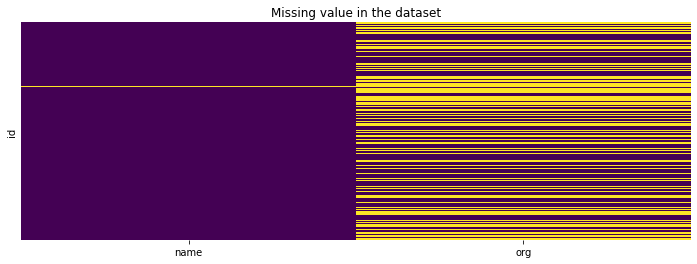

In [15]:
# Looking for Nans
plt.figure(figsize=(12,4))
sns.heatmap(df_authors.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

In [8]:
df_papers_1.head(2)

,venue_id,title,abstract,year,n_citation,page_start,page_end,issue,volume,keywords,fos,doi,pdf,url
id,,,,,,,,,,,,,,
0,0.0,3GIO.,NaN,2011.0,0.0,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
1,1.0,The relationship between canopy parameters and...,Drought is the first place in all the natural ...,2011.0,0.0,1930,1933,NaN,NaN,"['canopy parameters', 'canopy spectrum', 'diff...","['Agronomy', 'Moisture', 'Hydrology', 'Environ...",10.1109/IGARSS.2011.6049503,NaN,['http://dx.doi.org/10.1109/IGARSS.2011.6049503']


In [6]:
df_papers_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   venue_id    997774 non-null  float64
 1   title       999914 non-null  object 
 2   abstract    725185 non-null  object 
 3   year        999993 non-null  float64
 4   n_citation  996390 non-null  float64
 5   page_start  909832 non-null  object 
 6   page_end    905430 non-null  object 
 7   issue       425405 non-null  object 
 8   volume      551901 non-null  object 
 9   keywords    999658 non-null  object 
 10  fos         947228 non-null  object 
 11  doi         801980 non-null  object 
 12  pdf         212757 non-null  object 
 13  url         985363 non-null  object 
dtypes: float64(3), object(11)
memory usage: 114.4+ MB


In [7]:
df_papers_1.describe()

,venue_id,year,n_citation
count,997774.000000,999993.000000,996390.000000
mean,19287.435751,2004.145486,35.048667
std,36860.491348,28.777499,280.475730
min,0.000000,0.000000,0.000000
25%,1506.000000,2001.000000,1.000000
50%,3877.000000,2007.000000,6.000000
75%,13840.000000,2010.000000,23.000000
max,168736.000000,2300.000000,76991.000000


In [4]:
missing = round((df_papers_1.isna().sum() / df_papers_1.shape[0]) * 100, 2)
missing[missing > 0]

venue_id       0.22
title          0.01
abstract      27.48
n_citation     0.36
page_start     9.02
page_end       9.46
issue         57.46
volume        44.81
keywords       0.03
fos            5.28
doi           19.80
pdf           78.72
url            1.46
dtype: float64

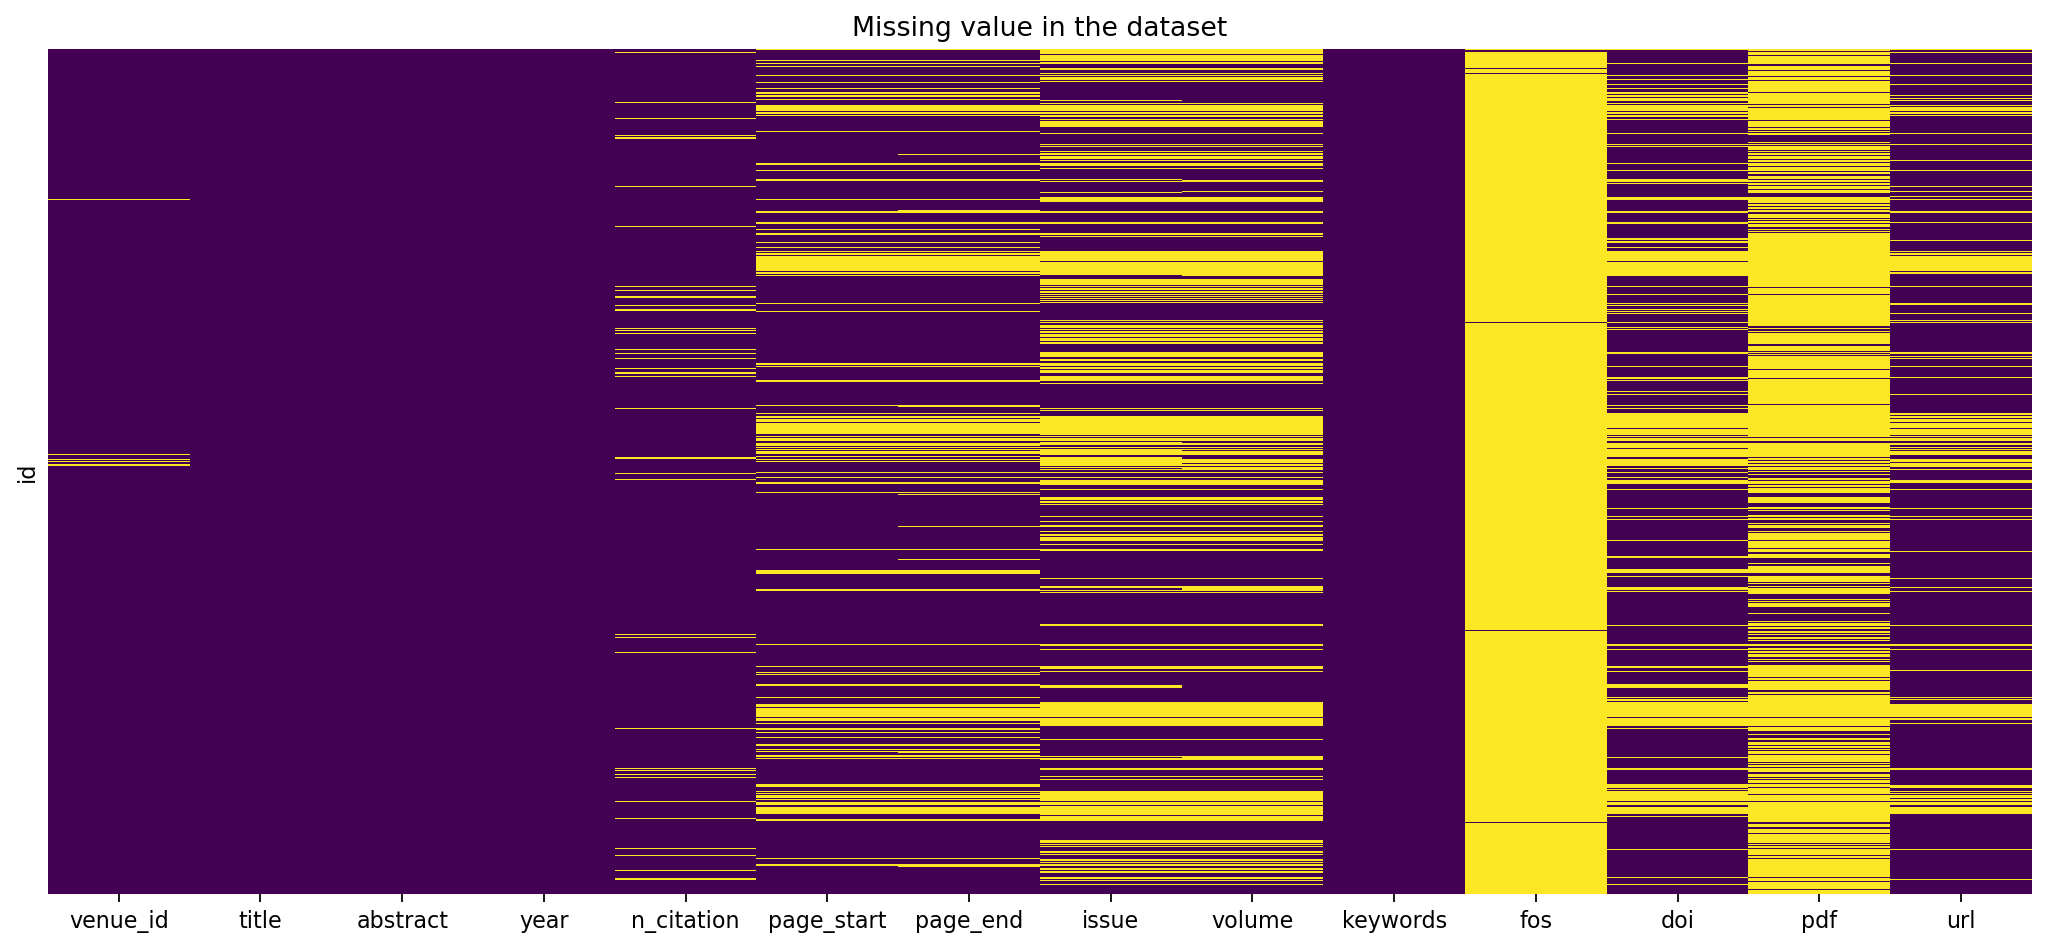

In [45]:
# Looking for Nans
plt.figure(figsize=(16,7), dpi=160)
sns.heatmap(df_papers_1.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

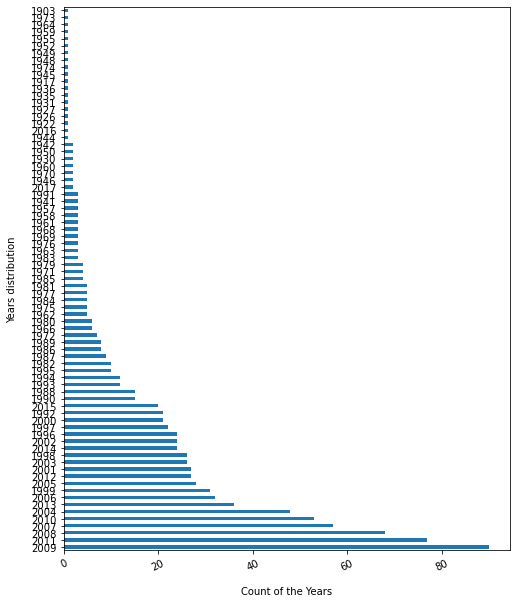

In [57]:
# Years
df_papers_1.year = df_papers_1.year.astype(int)
prob = df_papers_1.year.value_counts()
prob.plot(kind='barh', figsize=(8, 10))
plt.ylabel("Years distribution", labelpad=14)
plt.xlabel("Count of the Years", labelpad=14)
plt.xticks(rotation=25)
plt.show()

In [32]:
# venue_id
df_papers_1.venue_id.value_counts().head(12)

41.0     35
70.0     27
5.0      26
14.0     14
61.0     13
74.0     13
48.0     12
119.0    12
526.0    11
240.0    11
32.0     11
115.0    10
Name: venue_id, dtype: int64

In [34]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

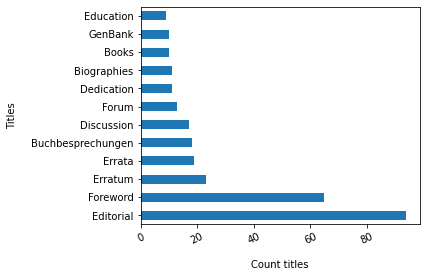

In [43]:
# title
prob = df_papers_1.title.str.strip(string.punctuation).value_counts().head(12)
prob.plot(kind='barh', figsize=(5, 4))
plt.ylabel("Titles", labelpad=14)
plt.xlabel("Count titles", labelpad=14)
plt.xticks(rotation=25)
plt.show()

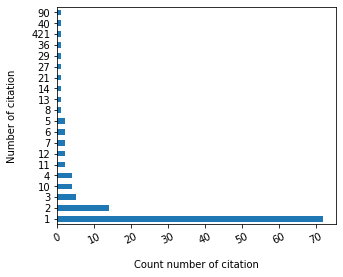

In [59]:
# Count of n_citations
df_papers_1.n_citation = df_papers_1.n_citation.dropna().astype(int)
prob = df_papers_1.groupby('n_citation').n_citation.count().value_counts()
prob.plot(kind='barh', figsize=(5, 4))
plt.ylabel("Number of citation", labelpad=14)
plt.xlabel("Count number of citation", labelpad=14)
plt.xticks(rotation=25)
plt.show()


In [68]:
len(df_papers_1.page_start.dropna())

438

In [69]:
len(df_papers_1.page_end.dropna())

794

In [75]:
df_papers_1.issue.dropna()

(628,)

In [122]:
# (
#     df_papers_1
#     .assign(keywords=lambda df: df.keywords.apply(lambda x: re.findall('(?<=\[)(.*?)(?=\])', x))
#     .apply(
#         lambda x: [item.strip() for item in x[0].replace("\'", '').split(',')]))
# )

#### Преобразование предложения в токены и очистка

In [22]:
def sent_to_words(sentences):
    for sent in tqdm(sentences):
        sent = re.sub(r'\S*@\S*\s?', '', str(sent))  # remove emails
        sent = re.sub(r'\s+', ' ', str(sent))  # remove newline chars
        sent = re.sub(r"\'", "", str(sent))  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  
# Convert to list
df_papers_1.abstract = df_papers_1.abstract.apply(str)
data = df_papers_1.abstract.values.tolist()
data = [d for d in data_words if d != ['nan']]
data_words = list(sent_to_words(data))
data_words = [d for d in data_words if d != ['nan']]
print(data_words[:11])

100%|██████████| 352/352 [00:00<00:00, 357.20it/s]

[['drought', 'is', 'the', 'first', 'place', 'in', 'all', 'the', 'natural', 'disasters', 'in', 'the', 'world', 'it', 'is', 'especially', 'serious', 'in', 'north', 'china', 'plain', 'in', 'this', 'paper', 'different', 'soil', 'water', 'content', 'control', 'levels', 'at', 'winter', 'wheat', 'growth', 'stages', 'are', 'performed', 'on', 'gucheng', 'ecological', 'meteorological', 'integrated', 'observation', 'experiment', 'station', 'of', 'cams', 'china', 'some', 'canopy', 'parameters', 'including', 'growth', 'conditions', 'dry', 'weight', 'physiological', 'parameters', 'and', 'hyperspectral', 'reflectance', 'are', 'measured', 'from', 'erecting', 'stage', 'to', 'milk', 'stage', 'for', 'winter', 'wheat', 'in', 'the', 'relationship', 'between', 'canopy', 'parameters', 'and', 'soil', 'relative', 'moisture', 'canopy', 'water', 'content', 'and', 'water', 'indices', 'of', 'winter', 'wheat', 'are', 'established', 'the', 'results', 'show', 'that', 'some', 'parameters', 'such', 'as', 'spad', 'and',

#### Создание биграмм и триграмм модели и лемматизирование

In [25]:
%%time
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out
data_ready = process_words(data_words)  # processed Text Data!

CPU times: user 2min 5s, sys: 218 ms, total: 2min 6s
Wall time: 2min 6s


#### Создадим модель темы

In [26]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)
pprint(lda_model.print_topics())

/opt/conda/lib/python3.9/site-packages/gensim/models/ldamodel.py:846: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)


[(0,
  '0.008*"work" + 0.007*"human" + 0.007*"communication" + 0.007*"natural" + '
  '0.007*"first" + 0.006*"physical" + 0.006*"animal" + 0.006*"sound" + '
  '0.006*"people" + 0.005*"generate"'),
 (1,
  '0.011*"study" + 0.011*"new" + 0.010*"use" + 0.008*"issue" + 0.007*"time" + '
  '0.007*"paper" + 0.007*"test" + 0.007*"system" + 0.006*"skin" + '
  '0.006*"year"'),
 (2,
  '0.015*"article" + 0.012*"science" + 0.010*"treatment" + 0.008*"effect" + '
  '0.007*"management" + 0.007*"record" + 0.006*"first_page" + 0.005*"public" + '
  '0.005*"medical" + 0.005*"application"'),
 (3,
  '0.021*"vol" + 0.017*"dermatology" + 0.012*"die" + 0.011*"vol_pp" + '
  '0.010*"dermatosis" + 0.010*"witten" + 0.009*"sensitization" + 0.008*"und" + '
  '0.007*"allergic" + 0.007*"sweat"')]


#### Отобразим доминирующую тему и ее процентный вклад в каждом документе

In [27]:
%%time
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

CPU times: user 6.14 s, sys: 23.7 ms, total: 6.17 s
Wall time: 6.16 s


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.8203,"work, human, communication, natural, first, ph...","[first, place, natural, disaster, world, espec..."
1,1,1.0,0.8852,"study, new, use, issue, time, paper, test, sys...","[process, variation, become, significant, prob..."
2,2,2.0,0.6119,"article, science, treatment, effect, managemen...","[represent, concern, address, work, approach, ..."
3,3,0.0,0.9580,"work, human, communication, natural, first, ph...","[btexture, movement, audio, visual, experience..."
4,4,1.0,0.8149,"study, new, use, issue, time, paper, test, sys...","[construct, system, cope, dynamically, change,..."
5,5,1.0,0.4653,"study, new, use, issue, time, paper, test, sys...","[grow, interest, potential, software, agent, t..."
6,6,0.0,0.5700,"work, human, communication, natural, first, ph...","[conjecture, large, integer, express, sum, non..."
7,7,1.0,0.8748,"study, new, use, issue, time, paper, test, sys...","[present, welcome, message, conference, procee..."
8,8,1.0,0.9720,"study, new, use, issue, time, paper, test, sys...","[pattern, find, biomolecular, datum, core, com..."
9,9,0.0,0.7280,"work, human, communication, natural, first, ph...","[language, xml, language, communication, human..."


#### Самое представительное предложение для каждой темы

In [28]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9678,"work, human, communication, natural, first, physical, animal, sound, people, generate","[graphically, depict, scene, intense, violence, use, simplified, stick, figure, character, style..."
1,1.0,0.9720,"study, new, use, issue, time, paper, test, system, skin, year","[pattern, find, biomolecular, datum, core, computational, molecular, biology, research, indeed, ..."
2,2.0,0.9148,"article, science, treatment, effect, management, record, first_page, public, medical, application","[brusque, farmer, driving, truck, big, fat, pig, back]"
3,3.0,0.9815,"vol, dermatology, die, vol_pp, dermatosis, witten, sensitization, und, allergic, sweat","[mit, output, orientierten, bewertung, der, bildungssystem, al, auch, der, eine, besondere, viel..."


#### Частота распределения количества слов в документах

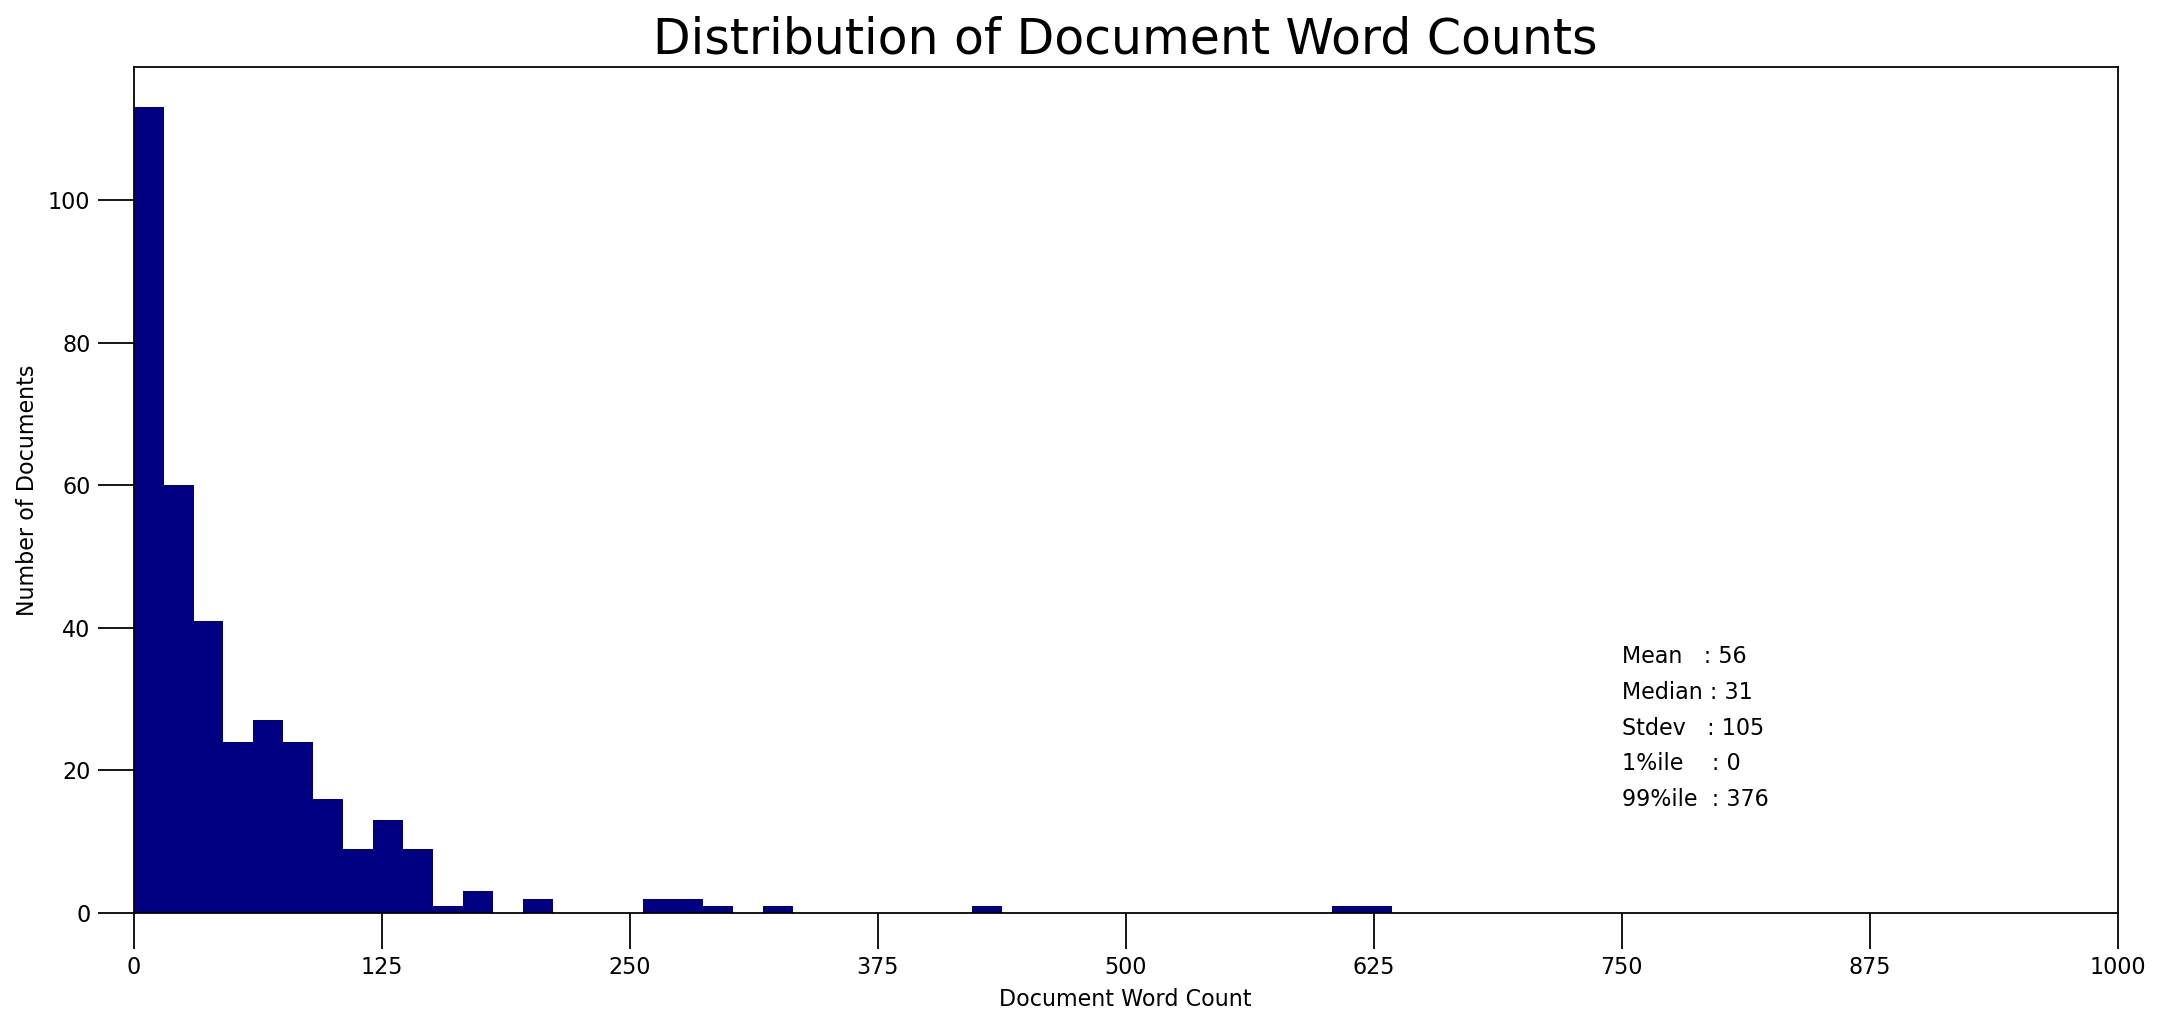

In [33]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(750, 35, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  30, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  25, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  20, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  15, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))
plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()


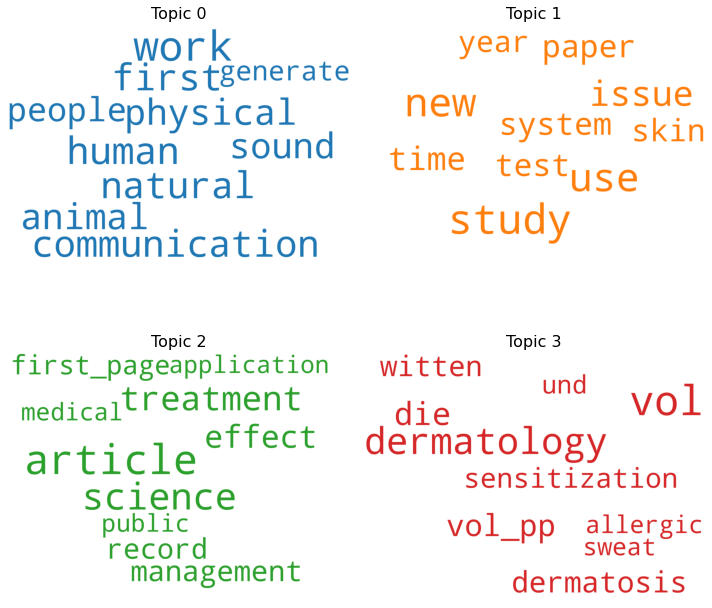

In [36]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Подсчет слов в тематических ключевых словах.

<ipython-input-37-8407c2cfe2a6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-37-8407c2cfe2a6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-37-8407c2cfe2a6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-37-8407c2cfe2a6>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


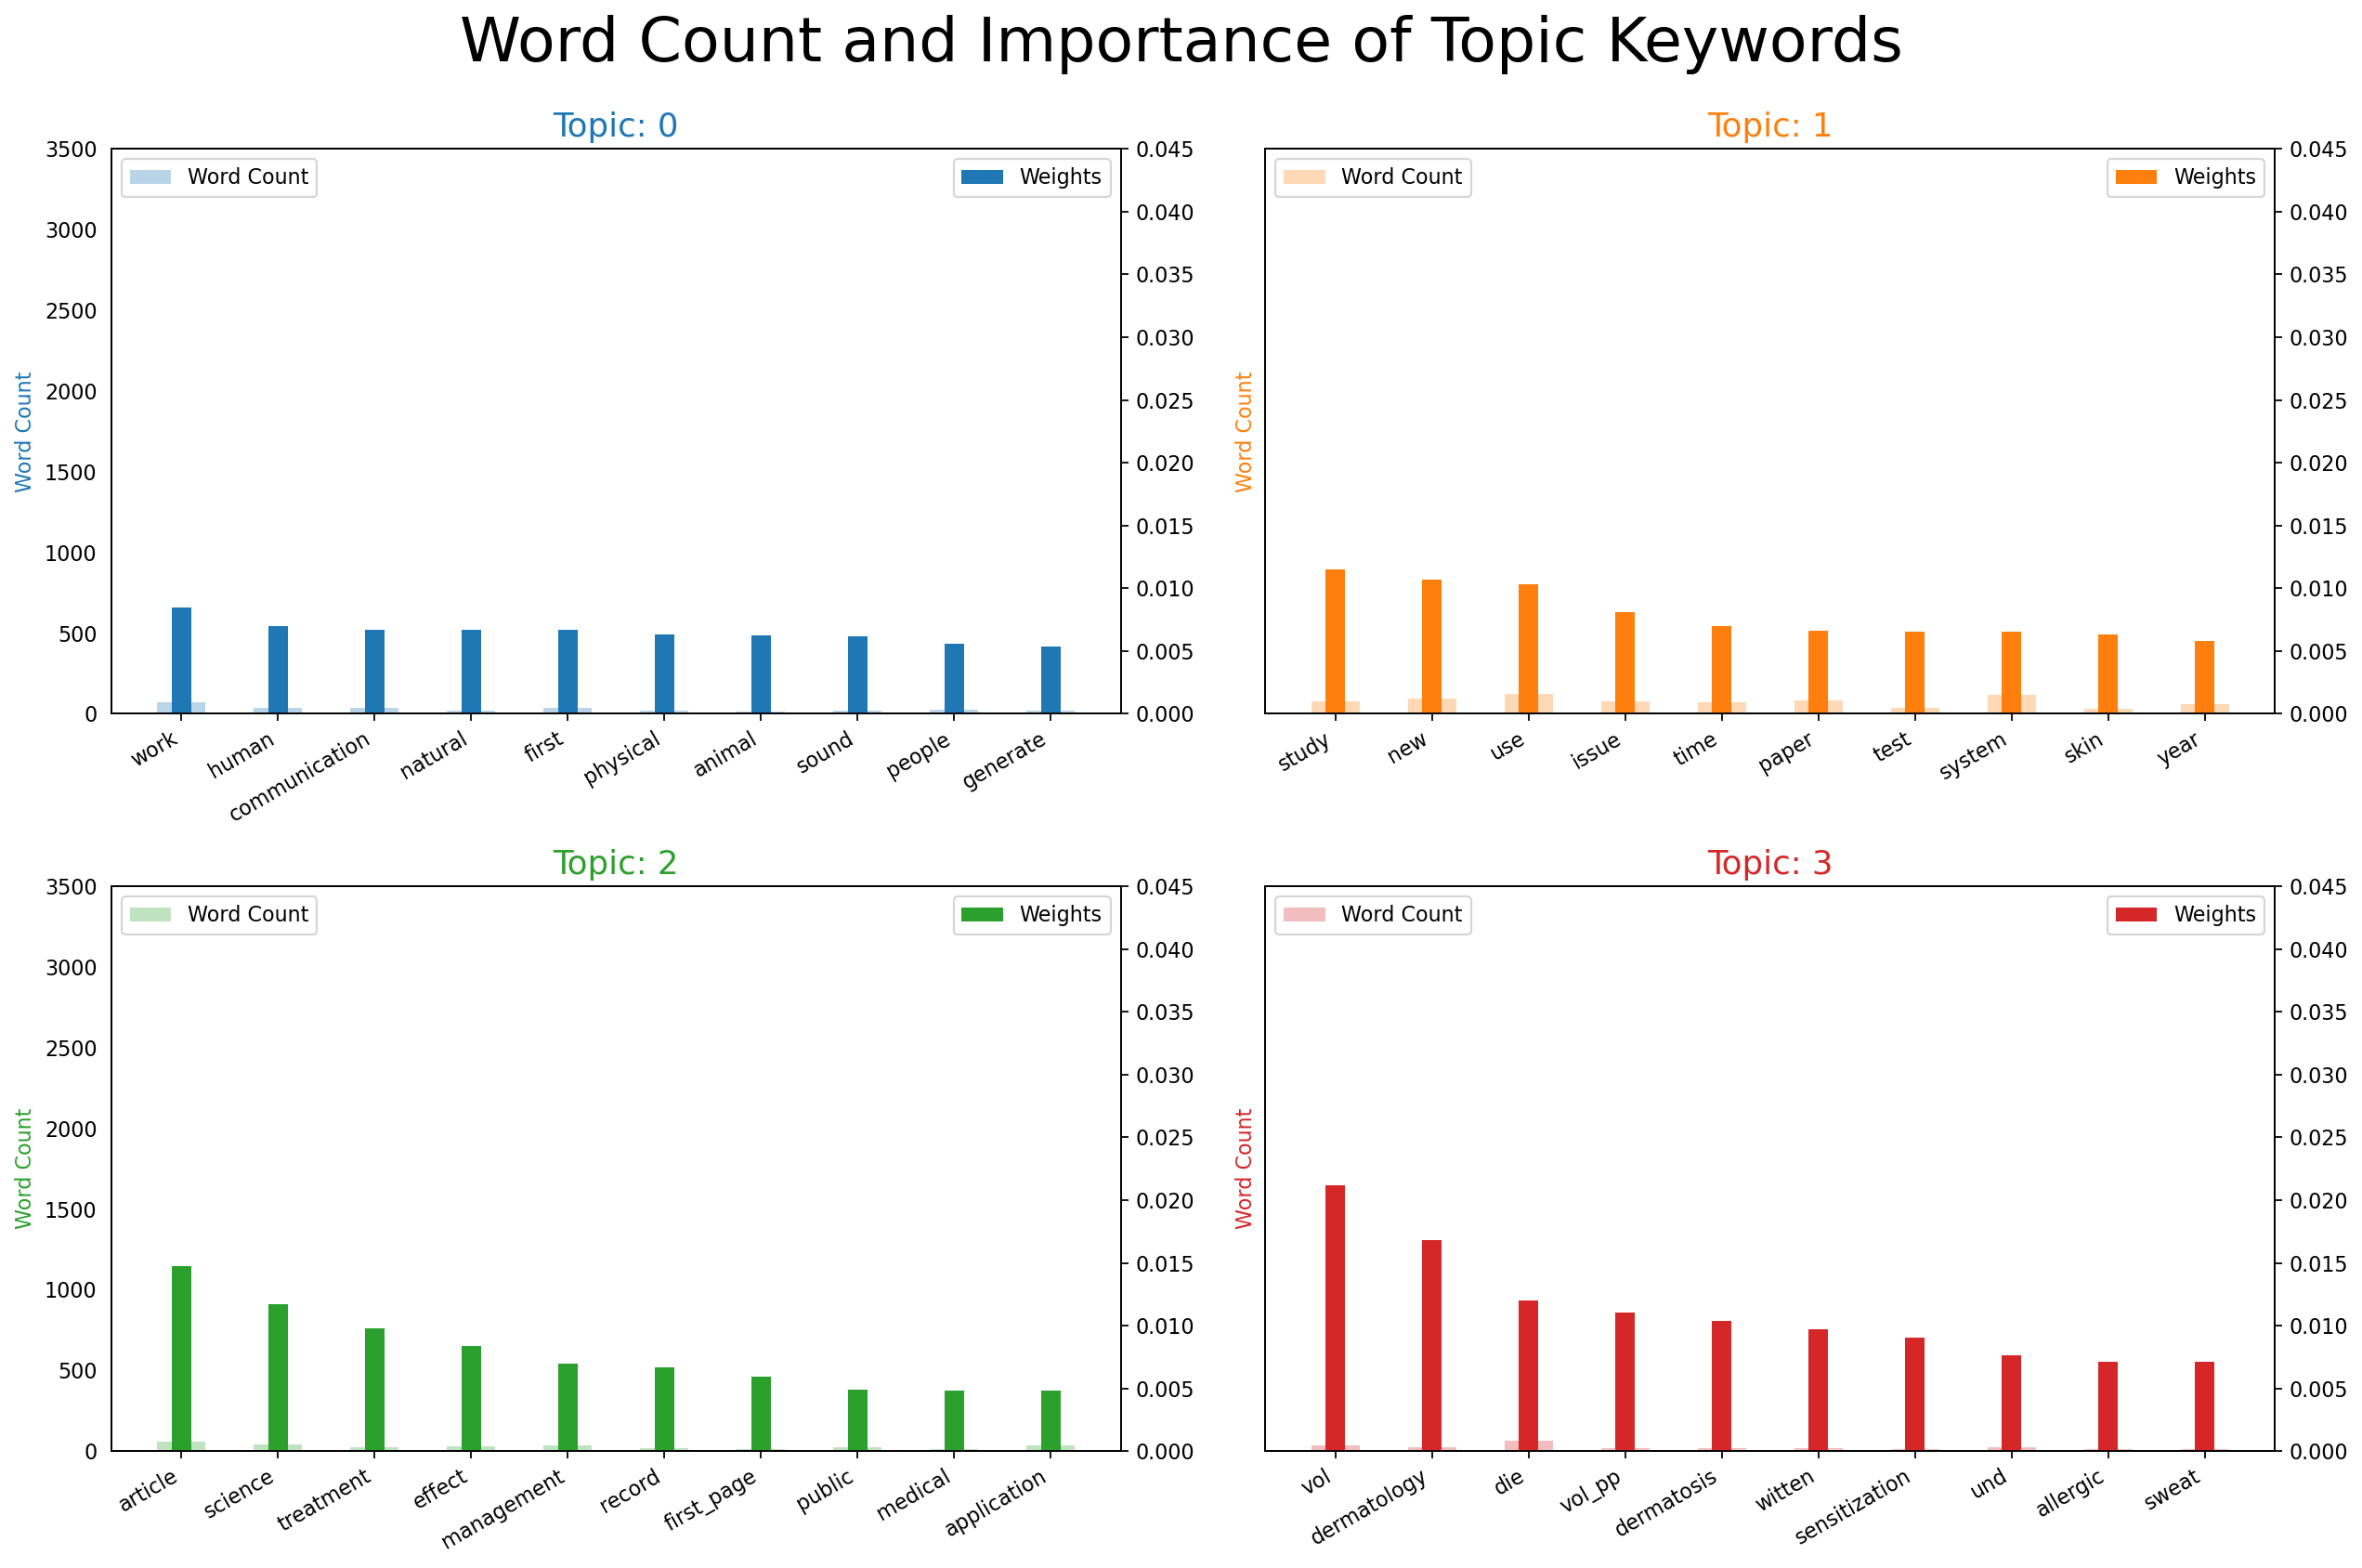

In [37]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])
df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.045); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=30, y=1.05)    
plt.show()

#### Таблица предложений, раскрашенных по темам

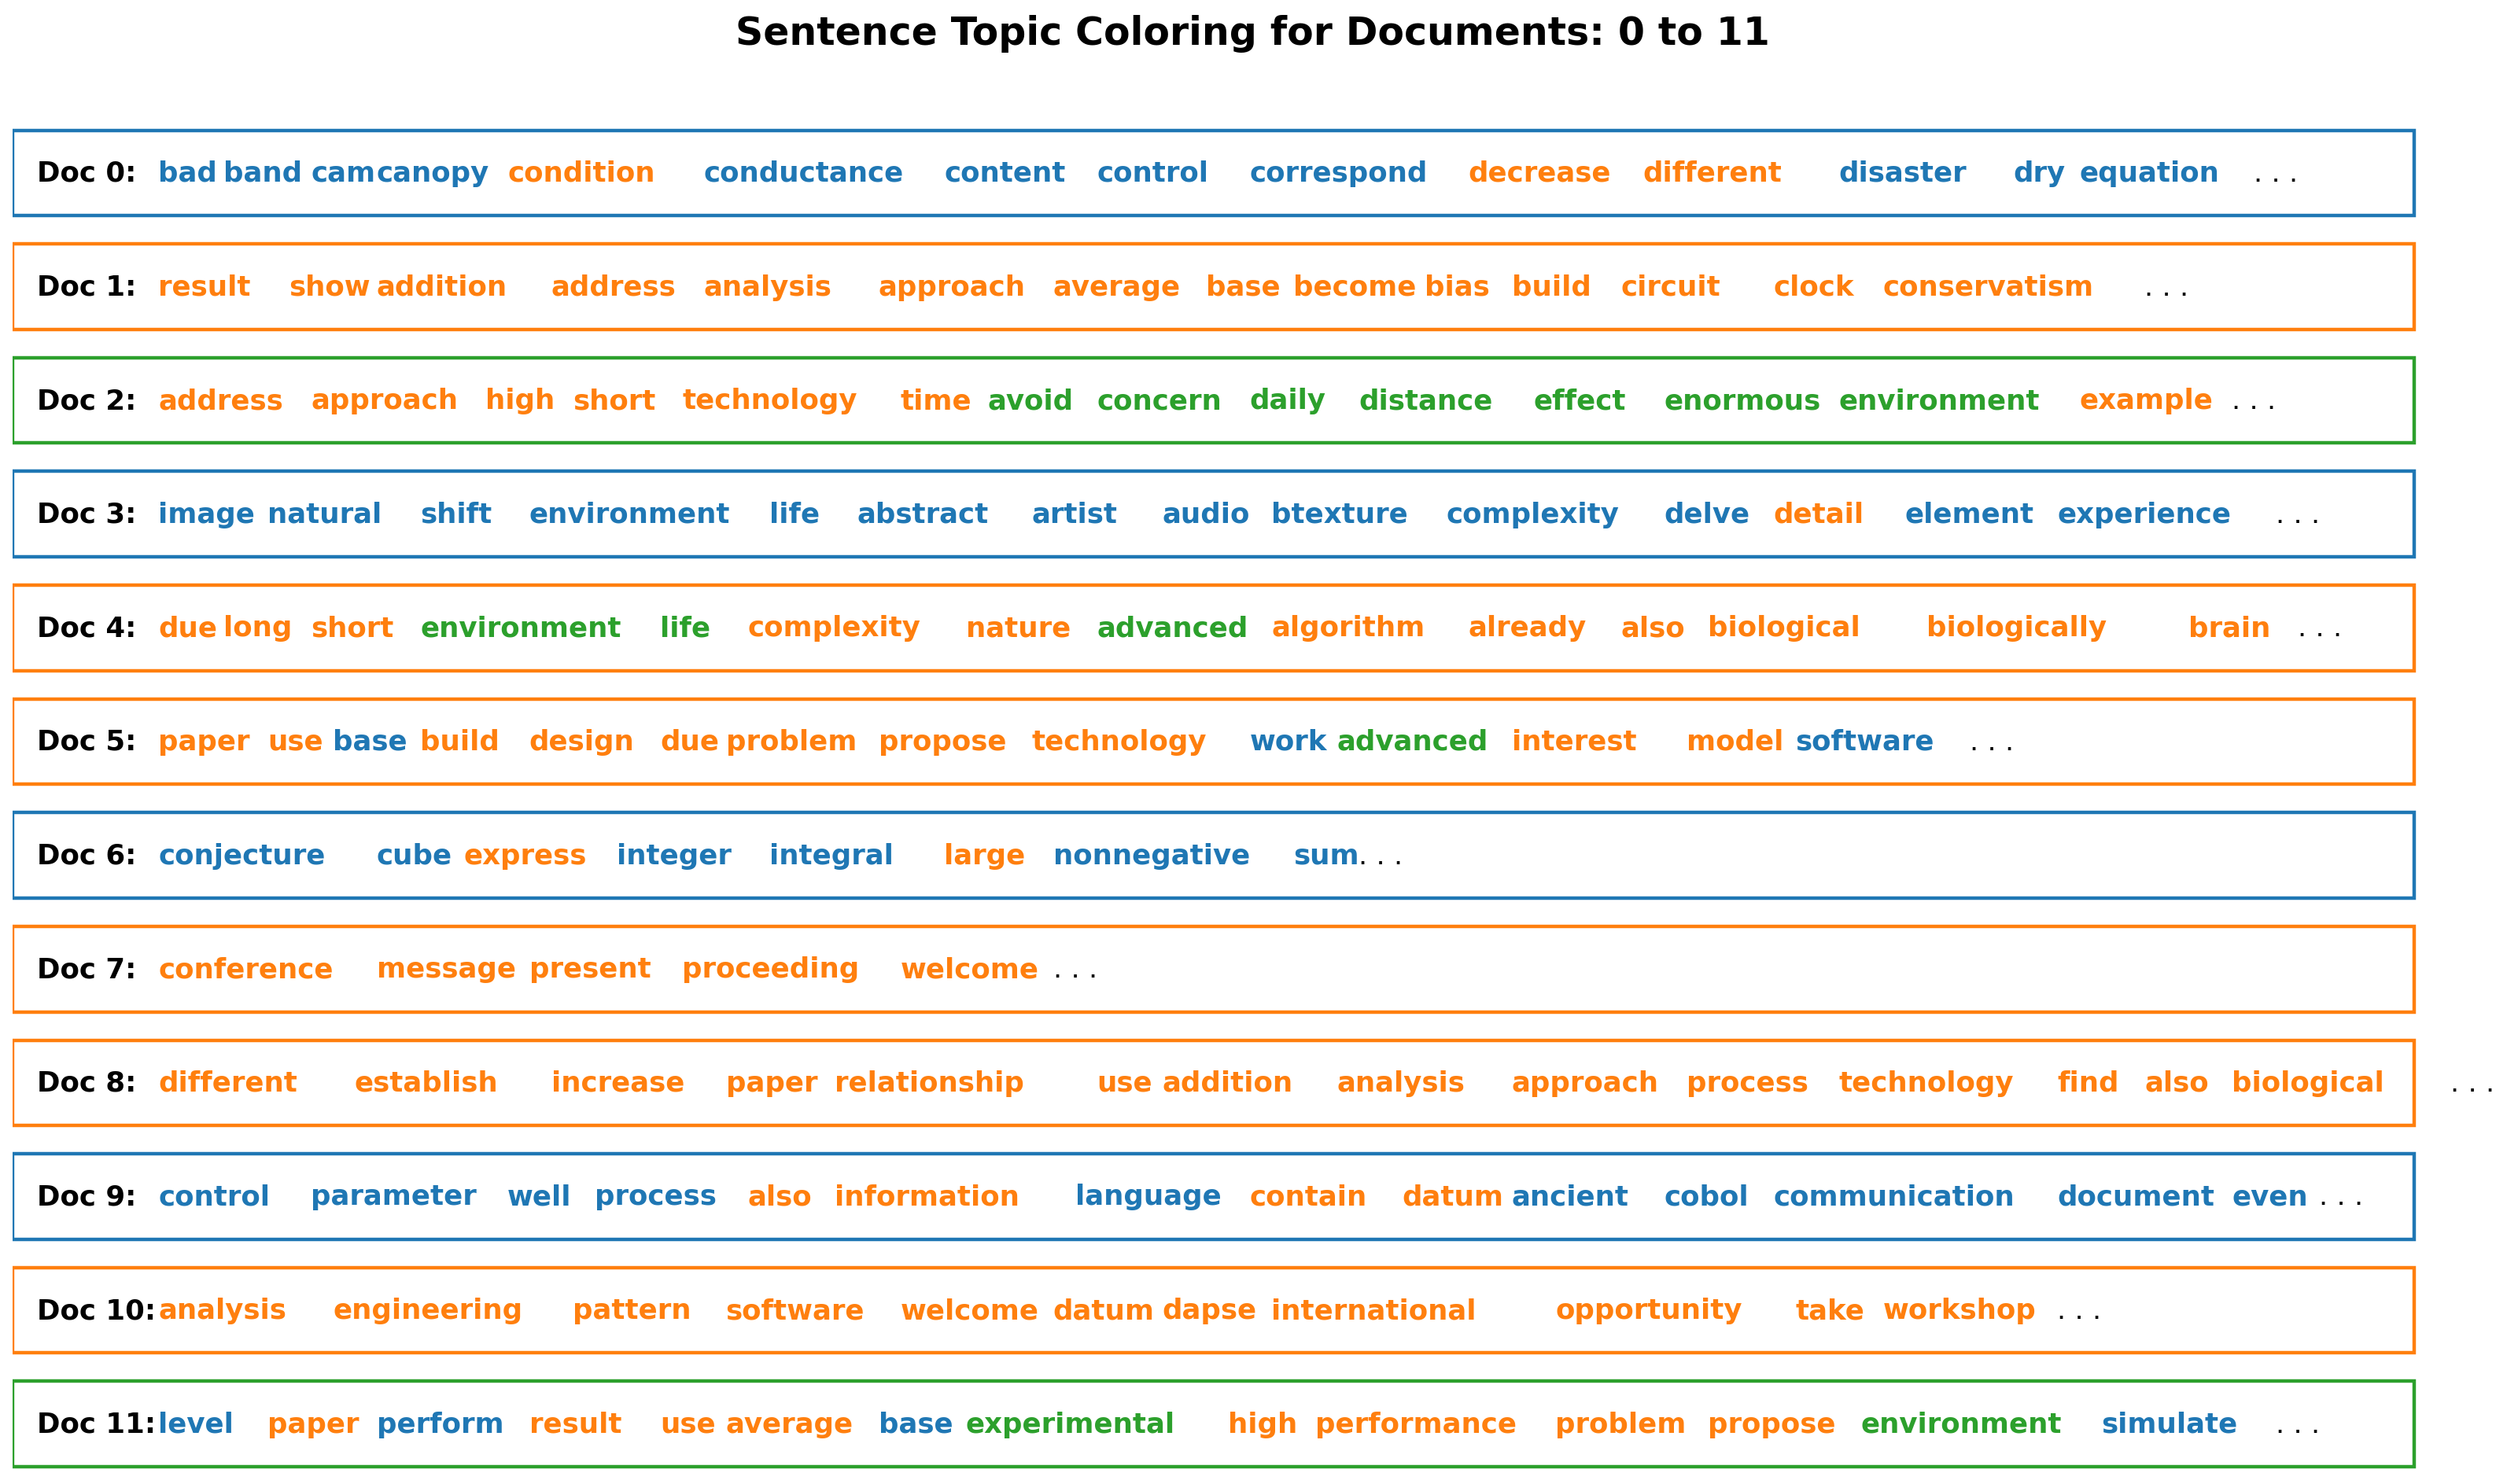

In [38]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [39]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)
dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            
# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()
# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]
df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

Количество документов для каждой темы, если назначить документ теме, имеющей наибольший вес в этом документе.

Количество документов по каждой теме путем суммирования фактического веса вклада каждой темы в соответствующие документы.

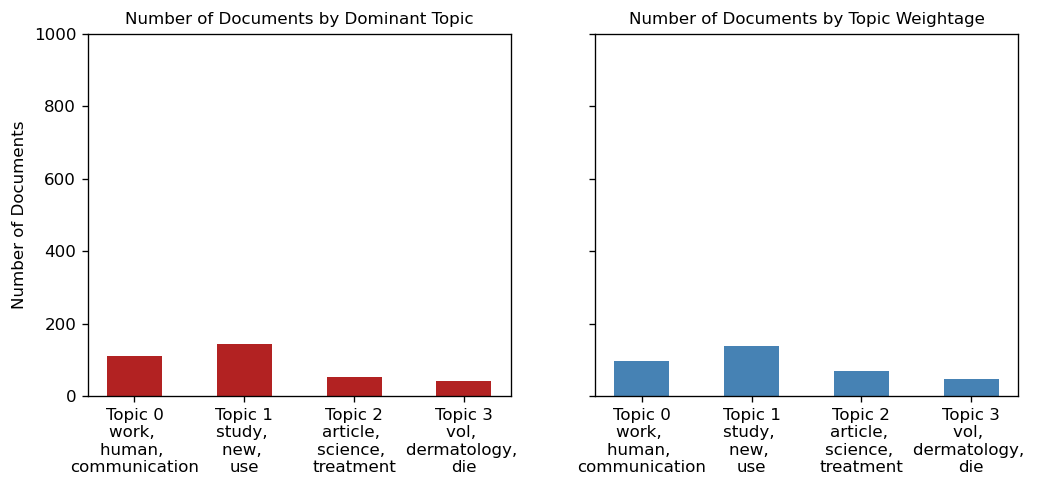

In [40]:
from matplotlib.ticker import FuncFormatter
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)
# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)
# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.show()

#### Схема кластеризации t-SNE

In [46]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 325 samples in 0.018s...
[t-SNE] Computed neighbors for 325 samples in 0.092s...
[t-SNE] Computed conditional probabilities for sample 325 / 325
[t-SNE] Mean sigma: 0.105746
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.750046
[t-SNE] KL divergence after 700 iterations: 0.253050


Loading BokehJS ...

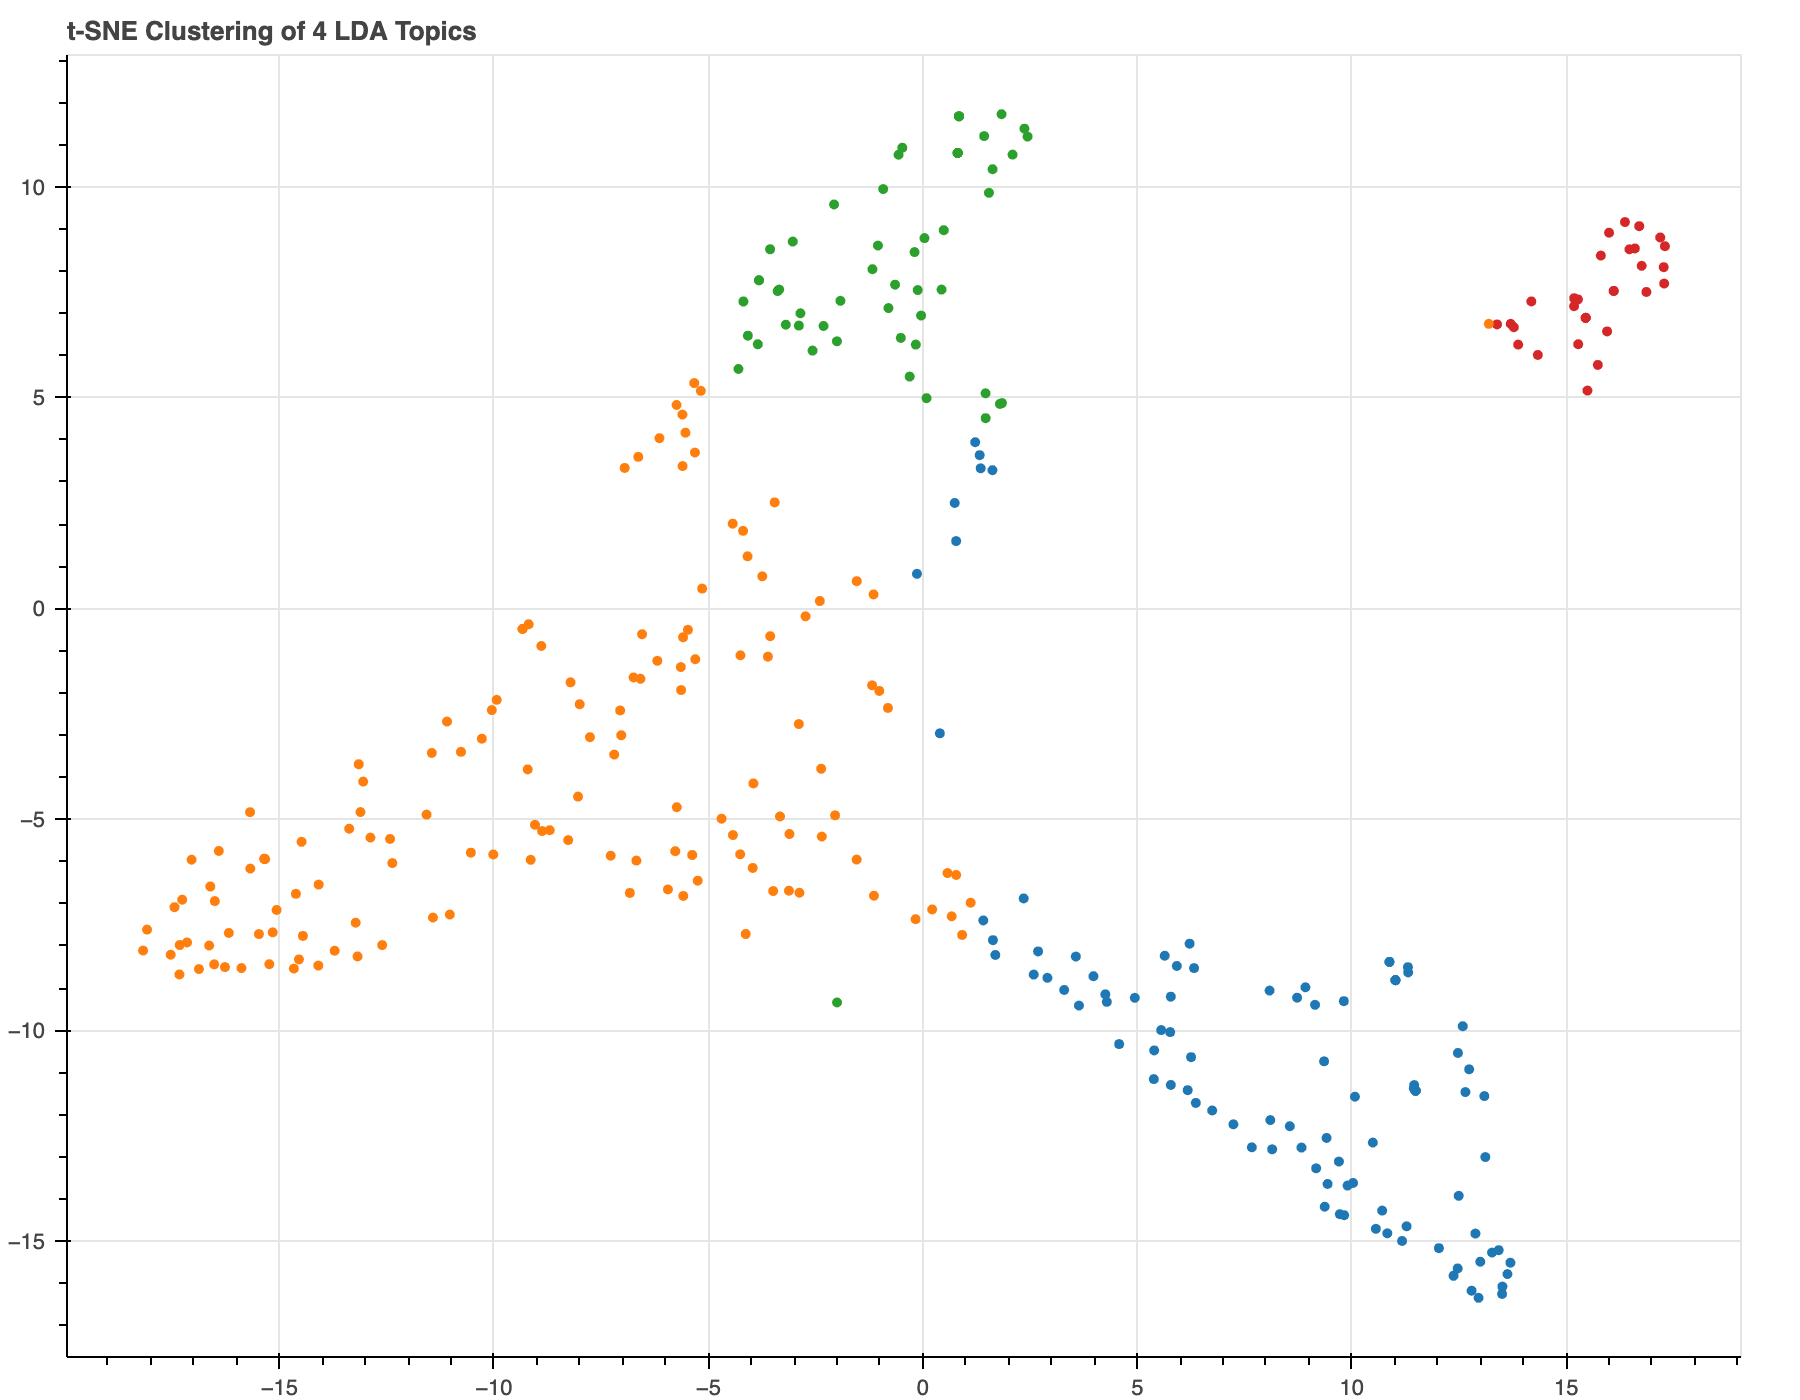

In [50]:
from IPython.display import Image
Image(filename='../data/pics/bokeh_plot.png')